In [68]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [69]:
import numpy as np
import pandas as pd

In [70]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [71]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [72]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [73]:
# What's in the database?

Inspector = inspect(engine)
table = Inspector.get_table_names()
table0 = Inspector.get_columns(table[0])

table1 = Inspector.get_columns(table[1])

for column in Inspector.get_columns(table[0]):
    print(column['name'],column['type'])
for column in Inspector.get_columns(table[1]):
    print(column['name'],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [74]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [75]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [76]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [77]:
# Choose a start date and end date for your trip. 
# Make sure that your vacation range is approximately 3-15 days total.

vacation_start = dt.date(2017, 7, 1)
vacation_end = dt.date(2017, 7, 16)

In [78]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [79]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Grabs the last date entry in the data table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

# Calculate the date 1 year ago from the last data point in the database

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print(last_year.strftime('%Y-%m-%d'))


# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date

rain_fall = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

rain_fall_df = pd.DataFrame(rain_fall)
rain_fall_df.head(12)
rain_fall_df.set_index('date')
rain_fall_df.head(5)


('2017-08-23',)


,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


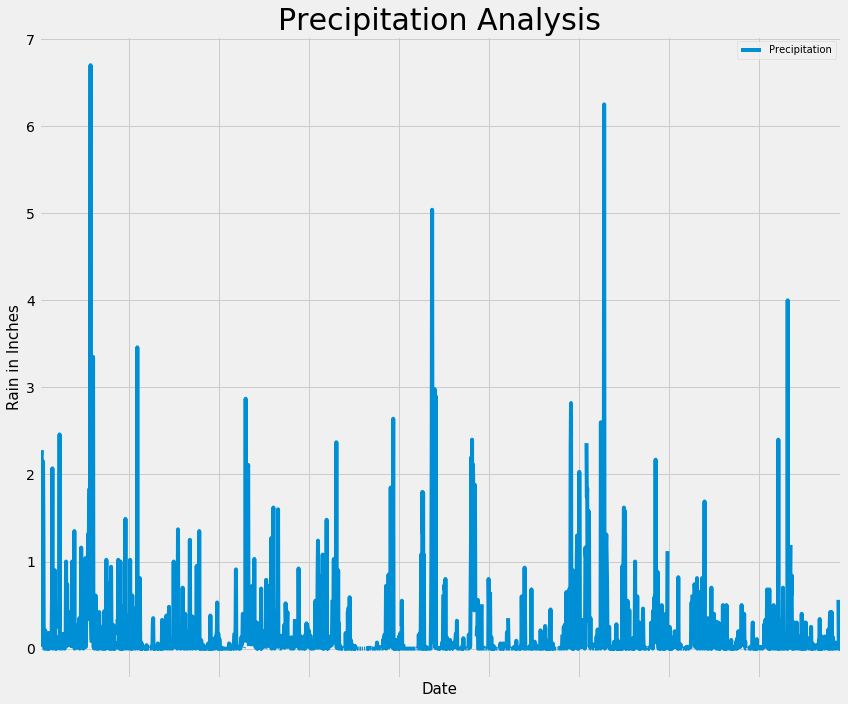

In [80]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.rcParams["figure.figsize"] = [12, 10]
rain_fall_df.plot('date','prcp')
plt.xlabel("Date",fontsize=15)
plt.ylabel("Rain in Inches",fontsize=15)
plt.title("Precipitation Analysis", fontsize=30)
plt.legend(["Precipitation"],loc='upper right',fontsize=10)
plt.xticks(visible=False)
plt.tight_layout()
plt.show()

In [81]:
# Use Pandas to calcualte the summary statistics for the precipitation data

rain_fall_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [82]:
# Design a query to show how many stations are available in this dataset?

locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [83]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active_stn = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = most_active_stn[0][0]    
print("The busiest Station was",busiest,"with",most_active_stn[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in most_active_stn:
    print("Station",station,"had",count, "weather observations.")

The busiest Station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.


In [84]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temp = session.query(Measurement.station,func.min(Measurement.tobs),\
                     func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station =='USC00519281').group_by(Measurement.station).all()

print (f"Most active station is {busiest}")
print (f"Lowest temperature :  {temp[0][1]}")
print (f"Highest temperature : {temp[0][2]}")
print ("Average temperature :","{0:.2f}".format(temp[0][3]))


Most active station is USC00519281
Lowest temperature :  54.0
Highest temperature : 85.0
Average temperature : 71.66


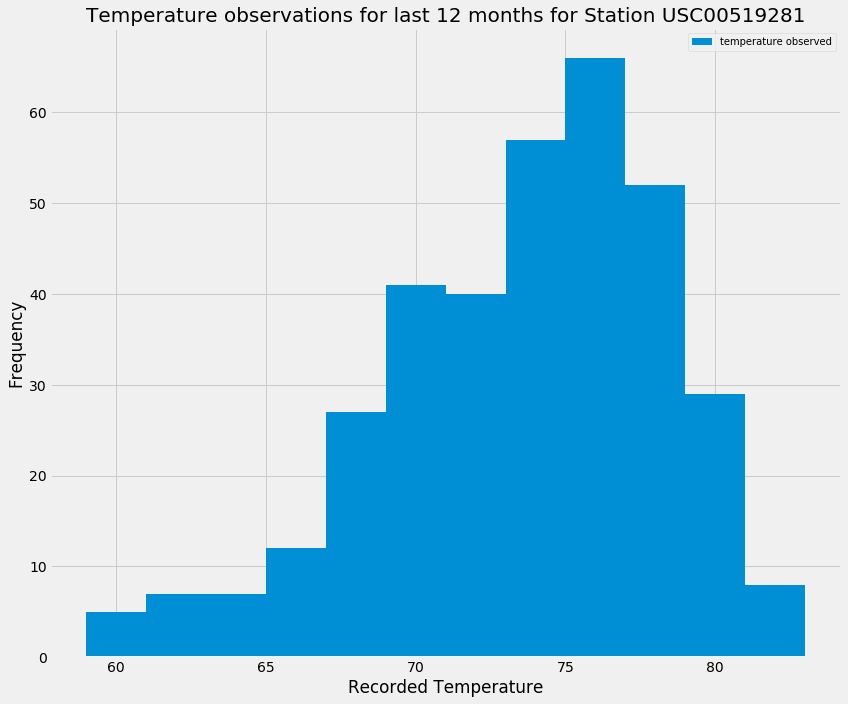

In [85]:
# Choose the station with the highest number of temperature observations.
#Highest_temp = session.query(Measurement.station,func.count(Measurement.tobs)).\
       #            order_by(Measurement.station).desc().all()
#print(Highest_temp)

temperature = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],bins=12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Temperature observations for last 12 months for Station " + busiest,fontsize=20)
plt.legend(["temperature observed"],loc='upper right',fontsize=10)

plt.tight_layout()
plt.show()


In [86]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [87]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

previous_year_start_period = vacation_start - dt.timedelta(days=365)

previous_year_end_period = vacation_end - dt.timedelta(days=365)
vacation_temp = calc_temps(previous_year_start_period,previous_year_end_period)
print(vacation_temp)

[(71.0, 77.06, 82.0)]


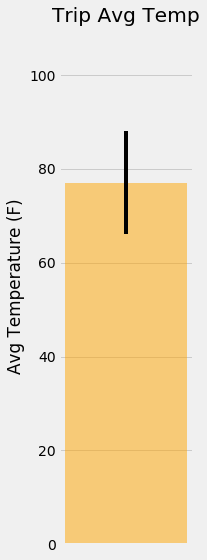

In [88]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


plt.figure(figsize=(3,8))

# Y-Error 'Max - Min'

error = vacation_temp[0][2] - vacation_temp[0][0]

x = np.arange(0.5,1,1.5)

# Plot
plt.bar(x,vacation_temp[0][1],yerr=error,color='orange',alpha=0.5)
plt.xticks([])
plt.grid(True)
plt.ylim(0,110)
plt.ylabel("Avg Temperature (F)")
plt.title("Trip Avg Temp")

plt.tight_layout()

plt.show()

In [89]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


vacation_previous = session.query(Measurement.station,Station.name, Station.latitude, \
                                  Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                    filter(Measurement.date >= previous_year_start_period).\
                    filter(Measurement.date <= previous_year_end_period).\
                    filter(Measurement.station == Station.station).\
                    group_by(Measurement.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()

print(vacation_previous)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 9.62), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 4.220000000000001), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.22), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.1), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.51), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.6000000000000001), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


# Optional Challenge Assignment 

['2017-07-15', '2017-07-14', '2017-07-13', '2017-07-12', '2017-07-11', '2017-07-10', '2017-07-09', '2017-07-08', '2017-07-07', '2017-07-06', '2017-07-05', '2017-07-04', '2017-07-03', '2017-07-02', '2017-07-01']


<Figure size 1080x720 with 0 Axes>

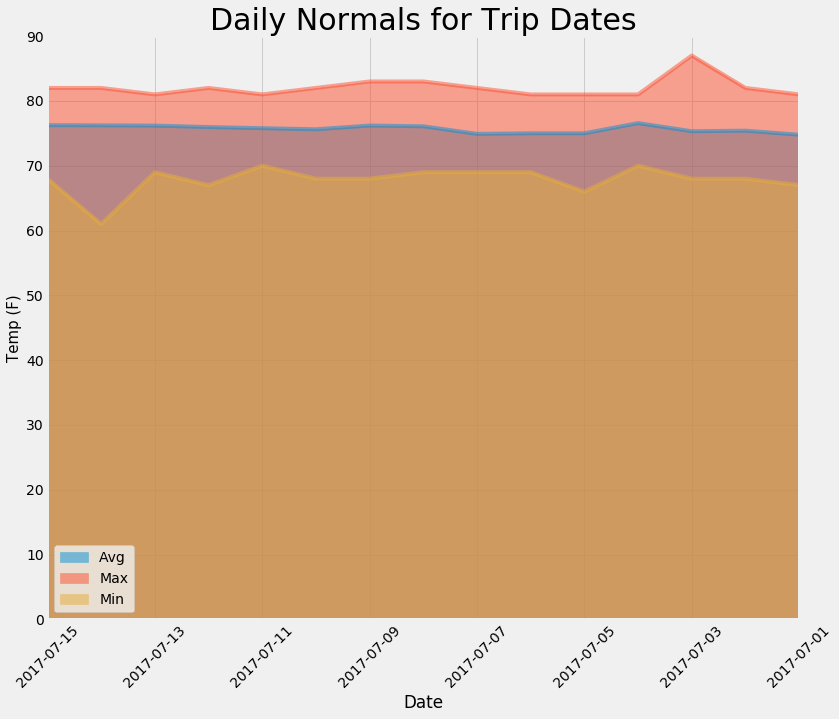

In [90]:

# Create a query that will calculate the daily normals 

# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)


def daily_normals(date):

    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        

    Returns:

        A list of tuples containing the daily normals, tmin, tavg, and tmax

    """
    

    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

daily_normals("07-01")

# Set the start and end date of the trip
# Use the start and end date to create a range of dates

vacation_dates = []
for item in range(14,-1,-1):
    store=vacation_end-dt.timedelta(days=15-item)
    store='{:%Y-%m-%d}'.format(store)
    vacation_dates.append(store)
    
print(vacation_dates)

# Stip off the year and save a list of %m-%d strings

month_date=[]

for item in vacation_dates:
    store=item[5:]
    month_date.append(store)
    
#print(month_date)

# Loop through the list of %m-%d strings and calculate the normals for each date

sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs),func.max(Measurement.tobs)]

temp_data=[]
for item in month_date:
    dates_data ={}
    result = session.query(*sel).filter(func.strftime('%m-%d', Measurement.date) == item).all()
    dates_data ['Min'] = result[0][0]
    dates_data ['Avg'] = result[0][1]
    dates_data ['Max'] = result[0][2]
    temp_data.append(dates_data)
    
#print(temp_data)

# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

dt_temp_df = pd.DataFrame(temp_data)
dt_temp_df.head()

# Iserting Date column

dt_temp_df ['Date'] = vacation_dates
dt_temp_df.set_index(dt_temp_df['Date'],inplace=True, drop=True)
dt_temp_df.head(15)

# Plot the daily normals as an area plot with `stacked=False`

plt.figure(figsize=(15,10))
xaxis = dt_temp_df['Date']
dt_temp_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.ylabel('Temp (F)', Fontsize=15)
plt.ylim(0,90)
plt.title('Daily Normals for Trip Dates', Fontsize=30)
plt.grid(alpha=1)
plt.show()
